# The `.upd()` method. Return a dataframe with updated variables.


The ```.upd()``` method extends pandas by giving the user a concise and expressive way to modify data in a `dataframe` using a syntax that a database-manager or macroeconomic modeler might find more natural. 

 

```.upd()``` can be used to:

 - Perform different types of  updates
 - Perform multiple updates each on a new line 
 - Perform changes over specific periods 
 - Use one input which is used for all time frames, or a separate input for each time 
 - Preserve pre-shock growth rates for out of sample time-periods 
 - Display results 
 
 
 :::{margin} Note:
 
 .upd() does not change the value of the dataframe upon which it operates, but its results can be assigned to a dataframe.  In the examples below the originating dataframe df is never overwritten.  It could be, by assigning the result of an upd() command to df, i.e.
 
 ```df.upd('B = 7')```
 
 would set B from th dataframe df equal to 7 and the function returns a dataframe that can be visualized.  The values of df are not changed in this example.  
 
 By contrast:
 
 ```df=df.upd('B = 7')```
 
 performs the same operation but assigns the results of the operation to df -- overwriting its earlier values.
 :::

:::{index} DataFrame; .upd() extension to update dataframes
:::

In [2]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')


In [3]:
# Prepare the notebook for use of modelflow 

# Jupyter magic command to improve the display of charts in the Notebook
%matplotlib inline

# Import pandas 
import pandas as pd

# Import the model class from the modelclass module 
from modelclass import model 

# functions that improve rendering of modelflow outputs
model.widescreen()
model.scroll_off();

<IPython.core.display.Javascript object>

:::{index} single: DataFrame; .upd() operators 
:::

## ```.upd()``` method operators 
Below are some of the operators that can be used in the ```.upd()``` method

**Types of update:** 

| Update to perform |Use this operator|
| :- | :---|
 Set a variable equal to the input| = 
 Add the input to the LHS variable | + 
 Set the variable to itself multiplied by the input | *
 Increase/Decrease the variable by a percent of itself - i.e. multiplies itself by (1+input/100) | %
 Set the growth rate of the variable to the input | =growth
 Change the growth rate of the variable to its current growth rate plus the input value in percentage points  | +growth 
 Specify the amount by which the variable should increase from its previous period level ($\Delta = var_t - var_{t-1}$)| =diff

:::{Warning}

The syntax of an update command requires that there be a space between variable names and the operators.

Thus ```df.upd("A = 7")``` is fine, but ```df.upd("A =7")``` will generate an error.

Similarly  ```df.upd("A * 1.1")``` is fine, but ```df.upd("A* 1.1")``` will generate an error.
:::

:::{index} single: DataFrame; .upd() examples
:::

 ## ```.upd()``` some examples
First, create a dataframe using standard pandas syntax.  In this instance with years as the index and a dictionary defining the variables and their data.

In [4]:
# Create a dataframe using standard pandas

df = pd.DataFrame({'B': [1,1,1,1,1,1],'C':[1,2,3,6,8,9],'E':[4,4,4,4,4,4]},index=[v for v in range(2020,2026)])
                  
df

,B,C,E
2020,1,1,4
2021,1,2,4
2022,1,3,4
2023,1,6,4
2024,1,8,4
2025,1,9,4


:::{index} single: DataFrame; .upd() to create new variable 
:::

### Use .upd to create a new variable 

With standard pandas a user can add a column (series) to a dataframe simply by assigning a adding to a dataframe.  For example:

```df['NEW2']=[17,12,14,15]```

```.upd()``` provides this functionality as well.

In [5]:
df.upd('c = 142') 


,B,C,E
2020,1,142,4
2021,1,142,4
2022,1,142,4
2023,1,142,4
2024,1,142,4
2025,1,142,4


:::{note}
The new variable name was entered as a lower case 'c' here.  Lowercase letters are not legal ```modelflow``` variable names.  The `.upd()` method knows that it is part of modelflow and knows this rule. As a result, it automatically translates lowercase entries into upper case so that the statement works.
:::
:::{note}
The automatic creation of new variables can be suspended by setting the option: `create = False`. For more look see the discussion of the method [.upd(,,create=True)](upd_create).
:::

:::{index} single: DataFrame; .upd() multiple lines
:::

:::{index} single: DataFrame; .upd() specific time periods
:::

## Multiple updates and specific time periods

The modelflow method ```.upd()``` takes a string as an argument.  That string can contain a single update command or can contain multiple commands (in this case the multi-line string needs to be passed using triple apostrophes `'''` as below.

Moreover by including a \<Begin End\> date clause in a given update command, the update will be restricted to the associated time period.

The below illustrates this, modifying two existing variables A, B over different time periods and creating two new variables, `C` and `D`.  

```{note}
The third line inherits the time period of the previous line.

Note also, the submitted string can include comments as well (denoted with the standard python # indicator).
```



In [6]:
df.upd("""
# Same number of values as years
<2021 2024> A = 42 44 45 46    # 4 years
<2020     > B = 200            # 1 year 
c = 500                        # Same period as previous line
<-0 -1> D = 33                   # All years 
""")

,B,C,E,A,D
2020,200,500,4,0.0,33.0
2021,1,2,4,42.0,33.0
2022,1,3,4,44.0,33.0
2023,1,6,4,45.0,33.0
2024,1,8,4,46.0,33.0
2025,1,9,4,0.0,33.0


:::{index} single: DataFrame; .upd() Time scope of commands
:::

:::{index} single: Boxes; Box   3. Time scope of .upd() commands
:::

:::{admonition} Box 3. Time scope of .upd() commands


The update command takes a variety of mathematical operators ```=, +, *, % =GROWTH, +GROWTH, =DIFF``` and applies them to data for the period set in the leading <>.

If the user wants to modify a series or group of series for only a specific point in time or a period of time, she can indicate the period in the command line.

 - If **one date** is specified the operation is applied to a single point in time
 - If **two dates**  are specifies the operation is applied over a period of time.

**The selected time period will persist** until re-set with a new time specification. This is useful if several variables are going to be updated for the same time period, but must be kept in mind if subsequent commands are to operate over a different time period. 

The time period can be reset to the full time-period by using the special \<-0 -1\> time period.  More generally:

 - -0 indicates the start of the `dataframe`
 - -1 indicates the end of the `dataframe` 
 
If no time is provided the `dataframe` start and end period will be used.  
:::


### Setting specific datapoints to specific values 

The ```=``` operator causes the left-hand side variable to be set equal to the values following the ```=``` operator.
:::{note} 
Either: 
  - Only one data point is provided. In this case its value is applied to all dates in the indicated period, or
  - The number of data points provided must match the number of dates in the period specified.
:::

In the example below:

* The first line sets the variable A during the specified period to specific values
* The second line sets the variable B to 200 in 2023
* The third line inherits the time period set in the second line (2023) and sets the variable C equal to 500.



In [7]:
df.upd("""
# Same number of values as years
<2021 2024> A = 42 44 45 46    # 4 years
<2023     > B = 200            # 1 year 
c = 500                        # inerits previous time-period specification
""")

,B,C,E,A
2020,1,1,4,0.0
2021,1,2,4,42.0
2022,1,3,4,44.0
2023,200,500,4,45.0
2024,1,8,4,46.0
2025,1,9,4,0.0


### =: Assign value(s) to a variable 

With standard pandas a user can add a column (series) to a dataframe simply by assigning a adding to a dataframe.  For example:

```df['NEW2']=[11,17,12,14,15,17]```

```df.upd('NEW2 = 11 17 12 14 15 17')``` provides this functionality as well.  

In [8]:
df.upd('NEW2 = 11 17 12 14 15 17')

,B,C,E,NEW2
2020,1,1,4,11.0
2021,1,2,4,17.0
2022,1,3,4,12.0
2023,1,6,4,14.0
2024,1,8,4,15.0
2025,1,9,4,17.0


:::{index} single: DataFrame; .upd() + operator
:::



### +: Adding  the specified  values to all values in a range

In the example below 42 is added to the pre-existing values of the variable B over the period 2022 and 2024.  

In [9]:
df.upd('''
# Or one number to all years in between start and end 
<2022 2024> B  +  42    # one value broadcast to 3 years 
''')

,B,C,E
2020,1,1,4
2021,1,2,4
2022,43,3,4
2023,43,6,4
2024,43,8,4
2025,1,9,4


:::{index} single: DataFrame; .upd() * operator
:::


### *: Multiplying all values in a range by the specified values

In the example below the pre-existing values of the variable A for years 2021, 2022 and 2023 are multiplied by three different numbers (42, 44 and 45 respectively).

In [10]:
df.upd('''
# Same number of values as years
<2021 2023> B *  42 44 55
''')

,B,C,E
2020,1,1,4
2021,42,2,4
2022,44,3,4
2023,55,6,4
2024,1,8,4
2025,1,9,4


:::{index} single: DataFrame; .upd() % operator
:::


### %: Increasing all  values in a range by a  specified percent amount 
In this example:
 - A new column  is generated with value 1 in every year
 - A is increased by 42 and 44% over the range 2021 through 2022.
 - B is increased by 10 percent in all years
 - C The values of C are overwritten and set to 100 for the whole range (because the previous line set the active range to  <-0 -1>)
 - C is decreased by 12 percent over the range 2023 through 2025.

In [11]:

df.upd('''
<-0 -1> A = 1
<2021 2022 > A %  42 44   # Two specific years / rows
<-0 -1> B % 10            # all rows 
C = 100                   # all rows persist 
<2023 2025> C % -12       # now only for 3 years 
''')


,B,C,E,A
2020,1.1,100,4,1.00
2021,1.1,100,4,1.42
2022,1.1,100,4,1.44
2023,1.1,88,4,1.00
2024,1.1,88,4,1.00
2025,1.1,88,4,1.00


:::{index} single: DataFrame; .upd() =GROWTH operator
:::


### =GROWTH: Set the percent growth rate to specified values

The `=GROWTH` operator sets the growth rate of the variable to the indicated level.


In [12]:
res = df.upd('''
# Same number of values as years
<-0 -1> A = 100
<2021 2022> A =GROWTH  1 5  
<2020> c = 100 
<2021 2025> c =GROWTH 2 
''')
print(f'Dataframe:\n{res}\n\nGrowth:\n{res.pct_change()*100}\n') # Explained b

Dataframe:
      B           C  E       A
2020  1  100.000000  4  100.00
2021  1  102.000000  4  101.00
2022  1  104.040000  4  106.05
2023  1  106.120800  4  100.00
2024  1  108.243216  4  100.00
2025  1  110.408080  4  100.00

Growth:
        B    C    E         A
2020  NaN  NaN  NaN       NaN
2021  0.0  2.0  0.0  1.000000
2022  0.0  2.0  0.0  5.000000
2023  0.0  2.0  0.0 -5.704856
2024  0.0  2.0  0.0  0.000000
2025  0.0  2.0  0.0  0.000000



:::{index} single: DataFrame; .upd() +GROWTH operator
:::

### +GROWTH: Add or subtract from the existing percent growth rate

The below example is a bit more complicated.

The first line sets the growth rate of A to 1 for the whole period.
The second line increases A by 1% in 2021.

The third line adds 2 to the growth rates of A in each period after 2021. For 2021 the growth rate was 1 so now it is two.  But the value of A in 2022 would not have changed, so its growth rate was actually negative.  Adding 2 to this growth rate results in a growth rates of a little more than 1.  Finally the growth rate in following years is 2 percent.

In [13]:


res =df.upd('''
<-0 -1> A = 1
<2021 > A =GROWTH  1  # All selected years set to the same growth rate
<2022 -1> A +growth   2  # Add to the existing growth rate these numbers  
''')
print(f'Dataframe:\n{res}\n\nGrowth:\n{res.pct_change()*100}\n')

Dataframe:
      B  C  E         A
2020  1  1  4  1.000000
2021  1  2  4  1.010000
2022  1  3  4  1.020200
2023  1  6  4  1.040604
2024  1  8  4  1.061416
2025  1  9  4  1.082644

Growth:
        B           C    E         A
2020  NaN         NaN  NaN       NaN
2021  0.0  100.000000  0.0  1.000000
2022  0.0   50.000000  0.0  1.009901
2023  0.0  100.000000  0.0  2.000000
2024  0.0   33.333333  0.0  2.000000
2025  0.0   12.500000  0.0  2.000000



:::{index} single: DataFrame; .upd() =diff operator
:::


###  =diff: Set the change in a variable to specific values  

$\Delta = var_t - var_{t-1} = some number$

Here sets the value of A in 2021 to 2 more than the value of 2020, and the 2022 value as 4 more than the **revised** value of 2021.

The second line creates a new variable "UPBY2" to the data frame and sets it equal to 100 for all periods,

The third line adds 2 to the previous periods value UPBY2.



In [14]:
df.upd('''
<-0 -1> A = 1
< 2021 2022> A =diff  2 4   # Same number of values as years
<2020 > UpBy2 = 100         # sets 2020 value of UPBy2 to 100 
<2021 2025> UpBy2 =diff  2  # increases by 2 from 2021 to 2025
''')


,B,C,E,A,UPBY2
2020,1,1,4,1.0,100.0
2021,1,2,4,3.0,102.0
2022,1,3,4,7.0,104.0
2023,1,6,4,1.0,106.0
2024,1,8,4,1.0,108.0
2025,1,9,4,1.0,110.0


:::{index} single: DataFrame; .upd() update several variables simultaneously
:::


## Update several variable in one line 
Sometime there is a need to update several variable with the same value over the same time frame. To ease this case .update can accept several variables in one line

In [15]:
df.upd('''
<2022 2024> h i j k =      40      # earlier values are set to zero by default
<2020>      p q r s =       1000   # All values beginning in 2020 set to 1000
<2021 -1>   p q r s =growth 2      # -1 indicates the last year of dataframe
''')

,B,C,E,H,I,J,K,P,Q,R,S
2020,1,1,4,0.0,0.0,0.0,0.0,1000.000000,1000.000000,1000.000000,1000.000000
2021,1,2,4,0.0,0.0,0.0,0.0,1020.000000,1020.000000,1020.000000,1020.000000
2022,1,3,4,40.0,40.0,40.0,40.0,1040.400000,1040.400000,1040.400000,1040.400000
2023,1,6,4,40.0,40.0,40.0,40.0,1061.208000,1061.208000,1061.208000,1061.208000
2024,1,8,4,40.0,40.0,40.0,40.0,1082.432160,1082.432160,1082.432160,1082.432160
2025,1,9,4,0.0,0.0,0.0,0.0,1104.080803,1104.080803,1104.080803,1104.080803


**Recall we have not overwritten df, so the df dataframe is unchanged.**

In [16]:
df

,B,C,E
2020,1,1,4
2021,1,2,4
2022,1,3,4
2023,1,6,4
2024,1,8,4
2025,1,9,4


:::{note}
The method `.upd()` only operates on one variable.  A command like `.upd('A = B')` would not work. For these kind of functions, use `.mfcalc()` (see next section).
:::

:::{index} single: DataFrame; .upd() options
:::

:::{index} single: DataFrame; .upd() keep_growth KG, NKG  option
:::



## The keep_growth option (--kg and --nkg)

When changing data and for certain kinds of simulations, it can sometime be useful to be able to update variables but keep the growth rate in subsequent periods unchanged. In database management this is frequently done when two time-series with different levels are spliced together. When forecasting this is useful if you have updated historical data but your views on future growth rates are unchanged.

The -kg or --keep_growth option instructs modelflow to calculate the growth rate of the existing pre-change series, and then use it to preserve the pre-change growth rates of the series for the periods that were **not** changed. 


### The default keep_growth behaviour

The ```keep_growth``` option determines how data in  the time periods after those where an update is executed are treated.  

If ```keep_growth``` is ```False``` then data in the sub-period after a change are left unchanged.

if ```keep_growth``` is set to "```True```" then the system will preserve the pre-change growth rate of the affected variable in the time period *after the change*. 

By default ```keep_growth``` is set to ```False```.

:::{note}
At the line level:
* ```keep_growth=True``` can be expressed as --kg
* ```keep_growth=False``` can be expressed as --nkg
:::

Consider the following concrete example. A ```dataframe``` df has two variables A and B, that each grow by 2% per period, with A initialized at a level of 100 and B at a level of 110 so that we can see each separately on a graph.



In [17]:
df = pd.DataFrame(100,
     index=[v for v in range(2020,2025)],
       columns=['A','B']) 

df=df.upd("""<2021 -1> A =growth 2
           <2020 -1>   B = 110
          <2021 -1>    B =growth 2
          """)
# Store these variables for later use in comparisons
df['A_ORIG']=df['A']
df['B_ORIG']=df['B']
df


,A,B,A_ORIG,B_ORIG
2020,100.000000,110.000000,100.000000,110.000000
2021,102.000000,112.200000,102.000000,112.200000
2022,104.040000,114.444000,104.040000,114.444000
2023,106.120800,116.732880,106.120800,116.732880
2024,108.243216,119.067538,108.243216,119.067538


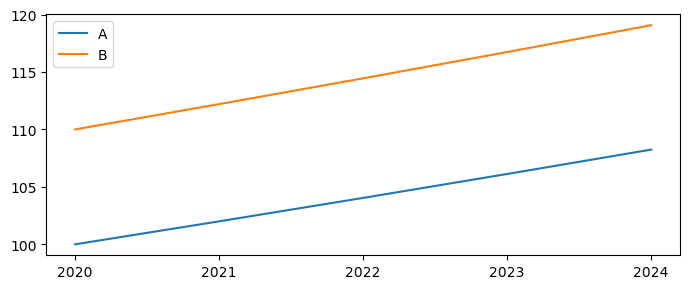

In [22]:
    df[['A','B']].plot(xticks=df.index,figsize=(7,3)); #the xticks option forces mathplitlib to only print x-axis values that exist in the index (no decimals)

The `.upd()` command below modifies both A and B by adding 5 to their levels in each of 2022 and 2023.  

For A, this is done with the `keep_growth` option set to `True` -- the `--kg` option in the code below.  This means that for A the growth rate after the shock period 2022-23 will be unchanged at 2 percent.

For series B the same shock is applied but with keep_growth set to `False` using the --nkg option.  

The keep_growth global variable is ignored in this instance as each line in the update is overriding it using the --kg option (`keep_growth=True`) and --nkg option (`keep_growth=False`).


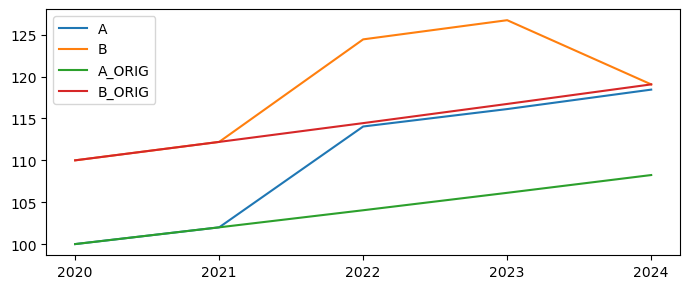

In [24]:
df=df.upd("""
            <2022 2023> A + 5 --kg
            <2022 2023> B + 5 --nkg
            """)

df[['A','B','A_ORIG','B_ORIG']].plot(xticks=df.index,figsize=(7,3));   

In the first example 'A' (the green and blue lines) the level of A is increased by 5 for two periods (2021-2022). The levels of the subsequent values are also increased because the previous growth rate (2%) is now applied to the new higher level of the data in 2022.

For the 'B' variable the same level change was input but because of the `--nkg` (equivalent to `keep_growth=False`) the periods after the change were unaffected. the shocked variable returns to its pre-shock level immediately in 2023.

Below are plots the growth rates of the two transformed series.

Here the growth in both series accelerates in 2022, by slightly less than 5 percentage points because a) the base of each is more than 100 in 2021 (because of the 2 percent growth in 2021). Substantially more in the case of  B, which was initialized at 110. In 2023 the growth rate of A returns to 2 percent, while the growth rate of B is actually negative because the level (see earlier graph) has fallen back to its original level.

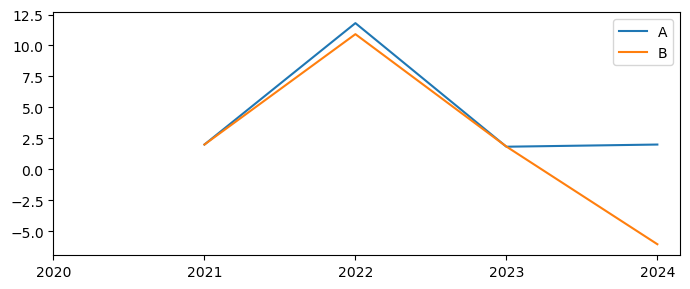

In [25]:
dfg=df[['A','B']].pct_change()*100
dfg.plot(xticks=dfg.index,figsize=(7,3));

:::{index} single: DataFrame; .upd() options
:::
:::{index} single: DataFrame; .upd() keep_growth KG, NKG  option
:::


### .upd(,,,keep_growth) some more examples





 Initialize a new dataframe, with some growth rate 

In [45]:
# instantiate a new dataframe with one column 'A' with avlue 100 everywhere and index 2020-2025
dftest = pd.DataFrame(100,
       index=[v for v in range(2020,2026)], # create row index
       # equivalent to index=[2020,2021,2022,2023,2024,2025] 
       columns=['A'])                                 # create column name
dftest

,A
2020,100
2021,100
2022,100
2023,100
2024,100
2025,100


In [46]:
# Update a to have growth rate accelerationg linearly by 1 from 1 Percent to 5 percent
original = dftest.upd('<2021 2025> a =growth 1 2 3 4 5')  
print(f'Levels:\n{original}\n\nGrowth:\n{original.pct_change()*100}\n')

Levels:
               A
2020  100.000000
2021  101.000000
2022  103.020000
2023  106.110600
2024  110.355024
2025  115.872775

Growth:
        A
2020  NaN
2021  1.0
2022  2.0
2023  3.0
2024  4.0
2025  5.0



**Now update A in 2021 to 2023 to a new value**

Below performs the same operation twice, the first time the updated value is assigned to the `dataframe` `nkg` and the default behaviour of ```keep_growth``` is ```False```

In the second example the ```-kg``` line option is specified, telling modelflow to maintain the growth rates of the dependent variable in the periods after the update is executed.

In [47]:
nokg = original.upd('''
<2021 2025>  a =growth 1 2 3 4 5 
<2021 2023>  a = 120  
''',lprint=0)

kg = original.upd('''
<2021 2025>  a =growth 1 2 3 4 5 
<2021 2023>  a = 120  --kg
''',lprint=0)


kg=kg.rename(columns={"A":"KG"})       #rename cols to facilitate display
nokg=nokg.rename(columns={"A":"NOKG"}) #rename cols to facilitate display
df=original.rename(columns={"A":"Orig"}) #rename cols to facilitate display

combo=pd.concat([kg,nokg,df], axis=1)
combo


print(f'Levels\n{combo}\n\nGrowth\n{combo.pct_change()*100}')

Levels
          KG        NOKG        Orig
2020  100.00  100.000000  100.000000
2021  120.00  120.000000  101.000000
2022  120.00  120.000000  103.020000
2023  120.00  120.000000  106.110600
2024  124.80  110.355024  110.355024
2025  131.04  115.872775  115.872775

Growth
        KG      NOKG  Orig
2020   NaN       NaN   NaN
2021  20.0  20.00000   1.0
2022   0.0   0.00000   2.0
2023   0.0   0.00000   3.0
2024   4.0  -8.03748   4.0
2025   5.0   5.00000   5.0


**Understanding the results**

In the first example where KG (keep_growth) **was set**, the level was set constant for three periods at 120 the rate of growth was 0 for the final two years of the set period.  But following this update, the level of A in 2023 is 120. With ```keep_Growth=True``` the KG variable growth at 2 percent per year in 2024 and 2025.

In the **--nkg** example, the levels of NOKG are the same as KG for 2020 through 2023, but because `--nkg` was selected the levels revert to their pre-shock values, which are lower than the 120 in 2023.  As a result the growth rate for NOKG is negative in 2024. The growth rate for 2024 remains 5 because neither the 2024 or 2025 data changed and therefore the 2025 the growth rate does not change. 



## .upd() with the option keep_growth set globally

Above the line level option `--keep_growth` or `--kg` was used to keep the growth rate (or not) for a given operation.

This works because by default the global `Keep_growth` options was set to false. In that context, implementing `--kg` at the line level temporarily set the keep_growth flag to true for the specific line (and those following).


In the example below we set the `keep_growth` flag to True globally and then use nkg at the line level. 

 To set keep_growth to True globally enter it as a specific option for the update command ```,keep_growth=True```.

In this context, all lines will keep the growth rate (unless overridden at the line level with `--nkg` or `--no_keep_growth`).
 - c,d are updated in 2022 and 2023 and keep the growth rates afterwards
 - e the `--no_keep_growth` in this line prevents the updating 2024-2025

In [48]:
# Create a data frame
dftest = pd.DataFrame(100,
       index=[v for v in range(2020,2025)], # create row index
       # equivalent to index=[2020,2021,2022,2023,2024] 
       columns=['A','B','C','D','E'])                                 # create column name 
dftest

,A,B,C,D,E
2020,100,100,100,100,100
2021,100,100,100,100,100
2022,100,100,100,100,100
2023,100,100,100,100,100
2024,100,100,100,100,100


:::{note} In the below .upd() command

```
dfres = dftest.upd('''
<2022 2023> c = 200 
<2022 2023> d = 300  
<2022 2023> e = 400  --no_keep_growth 
''',keep_growth=True)  # <=  Set keep_growth to True for the entirety of the command, 
                       # except for e where it is overridden by the --no_keep_growth flag
```

There are two keep_growth commands.  The final one is the global option (global to the execution of this update).  It is passed as an argument to the .upd() method ",keep_growth=True" and applies to every line in the command string (unless overridden).  In contrast, the single line command --no_keep_growth is inside the string passed to .upd() and applies only to the line on which it occurs.
:::

In [49]:
dfres = dftest.upd('''
<2022 2023> c = 200 
<2022 2023> d = 300  
<2022 2023> e = 400  --no_keep_growth 
''',keep_growth=True)  # <=  Set keep_growth to True for the entirety of the command, 
                       # except for e where it is overridden by the --no_keep_growth flag
print(f'Dataframe:\n{dfres}\n\nGrowth:\n{dfres.pct_change()*100}\n')

Dataframe:
        A    B      C      D    E
2020  100  100  100.0  100.0  100
2021  100  100  100.0  100.0  100
2022  100  100  200.0  300.0  400
2023  100  100  200.0  300.0  400
2024  100  100  200.0  300.0  100

Growth:
        A    B      C      D      E
2020  NaN  NaN    NaN    NaN    NaN
2021  0.0  0.0    0.0    0.0    0.0
2022  0.0  0.0  100.0  200.0  300.0
2023  0.0  0.0    0.0    0.0    0.0
2024  0.0  0.0    0.0    0.0  -75.0



:::{index} single: DataFrame; .upd() scale option
:::


## .upd(,,scale=\<number, default=1>) Scale the updates 

When running scenarios it can be useful to sensitivity analyses of model results, to better understand how the model responds when varying the intensity of a shock.

The scale option provides a mechanism for calculating a range shocks as a proportion of the initially indicated one.

When using the scale option, scale=0 implies no change (effectively the baseline) while scale=0.5 is a scenario half of the full severity.


In the example below `.upd()` is executed three times for severity equals 0. 0.5 and 1.  If the list passed to scale (named severity in this case) had five items in it, the update would be run five times -- one time for each item in the list.  


This example just prints outputs, a more interesting example would involve the solving a model using different levels of a given shock. 


In [50]:
dfinput=df.upd('A = 100')
print(f'input dataframe: \n{dfinput}\n\n')
for severity in [0,0.5,1]: 
    # First make a dataframe with some growth rate 
    res = dfinput.upd('''
    <2021 2025>
    a =growth 1 2 3 4 5 
    b + 10
    ''',scale=severity)
    print(f'{severity=}\nDataframe:\n{res}\n\nGrowth:\n{res.pct_change()*100}\n\n')
    #  
    # Here the updated dataframe is only printed. 
    # A more realistic use case is to simulate a model like this: 
    # dummy_ = mpak(res,keep='Severity {serverity}')    # more realistic 

input dataframe: 
            Orig      A
2020  100.000000  100.0
2021  101.000000  100.0
2022  103.020000  100.0
2023  106.110600  100.0
2024  110.355024  100.0
2025  115.872775  100.0


severity=0
Dataframe:
            Orig      A    B
2020  100.000000  100.0  0.0
2021  101.000000  100.0  0.0
2022  103.020000  100.0  0.0
2023  106.110600  100.0  0.0
2024  110.355024  100.0  0.0
2025  115.872775  100.0  0.0

Growth:
      Orig    A   B
2020   NaN  NaN NaN
2021   1.0  0.0 NaN
2022   2.0  0.0 NaN
2023   3.0  0.0 NaN
2024   4.0  0.0 NaN
2025   5.0  0.0 NaN


severity=0.5
Dataframe:
            Orig           A    B
2020  100.000000  100.000000  0.0
2021  101.000000  100.500000  5.0
2022  103.020000  101.505000  5.0
2023  106.110600  103.027575  5.0
2024  110.355024  105.088126  5.0
2025  115.872775  107.715330  5.0

Growth:
      Orig    A    B
2020   NaN  NaN  NaN
2021   1.0  0.5  inf
2022   2.0  1.0  0.0
2023   3.0  1.5  0.0
2024   4.0  2.0  0.0
2025   5.0  2.5  0.0


severity=1
Dataf

:::{index} single: DataFrame; .upd() lprint option
:::


## .upd(,,lprint=True ) prints values the before and after update  

The ```lPrint``` option of the method ```upd()``` is set to ```= False``` by default.  By setting it true, an update command will output the results of the calculation comparing the values of the dataframe (over the impacted period) before, after and the difference between the two.



In [51]:
dfinput.upd('''
# Same number of values as years
<2021 2022> A *  42 44
''',lprint=1);

Update * [42.0, 44.0] 2021 2022
A                    Before                After                 Diff
2021               100.0000            4200.0000            4100.0000
2022               100.0000            4400.0000            4300.0000


:::{index}  single: DataFrame; .upd() create option
:::



(upd_create)=
## .upd(,,create=True ) Requires the variable to exist  
Until now .upd has created variables if they did not exist in the input dataframe.

To catch misspellings the parameter ```create``` can be set to False. 
New variables will not be created, and an exception will be raised. 

Here Python's exception handling is used, so the notebook will continue to run the cells below. 

In [52]:
try:
    xx = df.upd('''
    # Same number of values as years
    <2021 2022> Aa *  42 44
    ''',create=False)
    print(xx)
except Exception as inst:
    xx = None
    print(inst) 


Variable to update not found:AA, timespan = [2021 2022] 
Set create=True if you want the variable created: 
